In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
results = []
for sax in range(3,31):
    with open(f'output/SAX_S2 match_{sax}/train_SAX_S2 match_{sax}.log', 'r') as f:
        m=0
        for _ in range(15222):
            s = f.readline()
            if "Best" in s:
                m = float(s.split(" ")[-2])
            if 'end' in s:
                results.append([sax,m])
                break
results = np.array(results)
results

array([[ 3.    ,  0.7646],
       [ 4.    ,  0.7518],
       [ 5.    ,  0.75  ],
       [ 6.    ,  0.7372],
       [ 7.    ,  0.7409],
       [ 8.    ,  0.7372],
       [ 9.    ,  0.7409],
       [10.    ,  0.7464],
       [11.    ,  0.7445],
       [12.    ,  0.7372],
       [13.    ,  0.7409],
       [14.    ,  0.7427],
       [15.    ,  0.7391],
       [16.    ,  0.7336],
       [17.    ,  0.7372],
       [18.    ,  0.7372],
       [19.    ,  0.7281],
       [20.    ,  0.7299],
       [21.    ,  0.7281],
       [22.    ,  0.7299],
       [23.    ,  0.7372],
       [24.    ,  0.7391],
       [25.    ,  0.7354],
       [26.    ,  0.7299],
       [27.    ,  0.7391],
       [28.    ,  0.7391],
       [29.    ,  0.7318],
       [30.    ,  0.7318]])

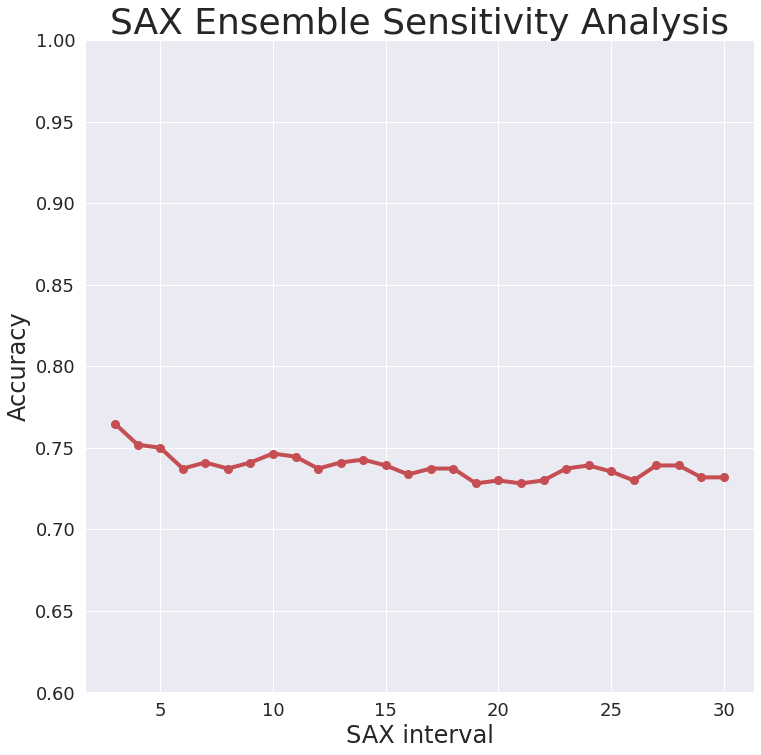

In [3]:
import seaborn as sns
sns.set()
plt.figure(figsize=[12,12])
plt.plot(results[:,0],results[:,1],marker='o',markersize=8 , color = 'r',linewidth=4)
plt.title('SAX Ensemble Sensitivity Analysis',size=36)
plt.ylabel("Accuracy",size=24)
plt.xlabel("SAX interval",size=24)
plt.ylim([0.6,1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

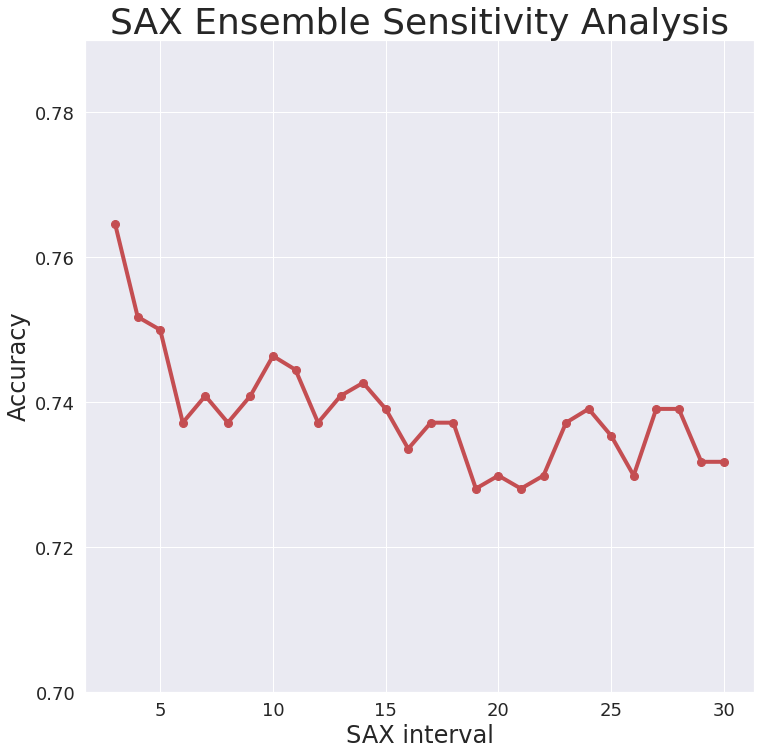

In [4]:
plt.figure(figsize=[12,12])
plt.plot(results[:,0],results[:,1],marker='o',markersize=8 , color = 'r',linewidth=4)
plt.title('SAX Ensemble Sensitivity Analysis',size=36)
plt.ylabel("Accuracy",size=24)
plt.xlabel("SAX interval",size=24)
plt.ylim([0.70,0.79])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

In [5]:
from scipy.stats import ttest_ind,binom_test
import glob
def calc(exp_name):
    
    r = glob.glob(f"{exp_name}*.csv")
    FOLDS = len(r)
    print(f"exp name - {exp_name} - folds - {len(r)}")
    DF_LIST = []
    for row in r:
        df = pd.read_csv(row)
        DF_LIST.append(df)
    df = pd.concat(DF_LIST)
    new_df = df.groupby("id").mean()
    res_id = new_df.values.round(0)[:,1:]
    res = df[['pred','gt']].values
    acc_test = sum(res[:,1]==res[:,0])/len(res)
    pvalue_test = float(binom_test(sum(res[:,0]==res[:,1]),len(res),alternative='greater',p=0.01))
    cm = confusion_matrix(res[:,1],res[:,0])
    
    name = r[0].split("/")[-1].split("_fold")[0]
    with open(f'output/{name}/train_{name}.log', 'r') as f:
        CM = [[],[],[],[],[]]
        AC = [[],[],[],[],[]]
        for fold in range(0,FOLDS):
            for _ in range(15222):
                s = f.readline()
                if "Accuracy_id" in s:
                    AC[fold].append(float(s.split("Accuracy_id: ")[-1].replace("\n",""))) 
                elif "cm_id" in s:
                    r = s.split("[[")[-1].split("]")[0].split(" ")
                    if "" in r:
                        r.remove("")
                    if "" in r:
                        r.remove("")
                    r0 = np.array(r).astype(int)
                    s = f.readline()
                    r1 = s.split("[")[-1].split("]")[0].split(" ")
                    if "" in r1:
                        r1.remove("")
                    if "" in r1:
                        r1.remove("")
                    r1 = np.array(r1).astype(int)
                    CM[fold].append([r0,r1])
                if 'end' in s:
                    break
    for fold in range(FOLDS):
        if fold==0:
            cm_id = np.array(CM[fold][np.array(AC[fold]).argmax()])
        else:
            cm_id +=np.array(CM[fold][np.array(AC[fold]).argmax()])
    acc_id = (cm_id[0,0]+cm_id[1,1])/cm_id.sum()
    pvalue_id = float(binom_test(sum(res_id[:,0]==res_id[:,1]),len(res_id),alternative='greater',p=0.01))
    tpr = cm[1,1] / (cm[1,0]+cm[1,1])
    tnr = cm[0,0] / (cm[0,0]+cm[0,1])
    tpr_id = cm_id[1,1] / (cm_id[1,0]+cm_id[1,1])
    tnr_id = cm_id[0,0] / (cm_id[0,0]+cm_id[0,1])
#     print(f"per test - acc - {acc_test} - pvalue {pvalue_test}")
#     print(f"per id - acc - {acc_id} - pvalue {pvalue_id}")
    return pd.DataFrame([[exp_name,acc_test,tpr,tnr,acc_id,pvalue_id,tpr_id,tnr_id,FOLDS]],columns=['exp_name','acc_eeg',"tpr_eeg","tnr_eeg",'acc_id',"pvalue_id","tpr_id","tnr_id","folds"])

In [6]:
data = [row for row in glob.glob("output/*") if "csv" not in row and 'best' not in row and 'SAX_S2_match_' not in row and "s2" in row and 'new_raw_lstm_s2' not in row]
print(data)
df_list = []
for exp in data:
    df = calc(exp)
    df_list.append(df)
df = pd.concat(df_list)
df = df.sort_values(["acc_id","acc_eeg"])
df

['output/new_raw_lstm_raw_cnn_s2', 'output/raw_cnn_s2', 'output/new_sax_lstm_tabular_s2', 'output/new_raw_lstm_raw_cnn_tabular_s2', 'output/ica_cnn_s2', 'output/new_sax_lstm_raw_cnn_tabular_s2', 'output/new_sax_lstm_ica_cnn_tabular_s2', 'output/new_sax3_lstm_s2', 'output/sax19_lstm_raw_cnn_tabular_s2', 'output/new_raw_lstm_tabular_s2', 'output/change_point_lstm_s2', 'output/prefixspan_lstm_s2']
exp name - output/new_raw_lstm_raw_cnn_s2 - folds - 5
exp name - output/raw_cnn_s2 - folds - 5
exp name - output/new_sax_lstm_tabular_s2 - folds - 5
exp name - output/new_raw_lstm_raw_cnn_tabular_s2 - folds - 4
exp name - output/ica_cnn_s2 - folds - 5
exp name - output/new_sax_lstm_raw_cnn_tabular_s2 - folds - 5
exp name - output/new_sax_lstm_ica_cnn_tabular_s2 - folds - 5
exp name - output/new_sax3_lstm_s2 - folds - 5
exp name - output/sax19_lstm_raw_cnn_tabular_s2 - folds - 5
exp name - output/new_raw_lstm_tabular_s2 - folds - 5
exp name - output/change_point_lstm_s2 - folds - 5
exp name - out

,exp_name,acc_eeg,tpr_eeg,tnr_eeg,acc_id,pvalue_id,tpr_id,tnr_id,folds
0,output/change_point_lstm_s2,0.648894,0.879064,0.247012,0.743802,1.711568e-132,0.974684,0.309524,5
0,output/prefixspan_lstm_s2,0.636561,0.934969,0.115538,0.800000,3.638586e-121,0.924051,0.560976,5
0,output/new_sax_lstm_tabular_s2,0.705840,0.882487,0.397410,0.811475,2.254772e-161,0.909091,0.644444,5
0,output/new_raw_lstm_tabular_s2,0.701850,0.868226,0.411355,0.819672,1.286313e-146,0.922078,0.644444,5
0,output/new_raw_lstm_raw_cnn_tabular_s2,0.722727,0.841993,0.511950,0.824742,8.107932e-132,0.919355,0.657143,4
0,output/new_sax3_lstm_s2,0.713457,0.833428,0.503984,0.827869,1.329763e-171,0.844156,0.800000,5
0,output/raw_cnn_s2,0.734131,0.826583,0.572709,0.836066,1.663846e-179,0.935065,0.666667,5
0,output/new_sax_lstm_ica_cnn_tabular_s2,0.735945,0.852253,0.532869,0.836066,5.161206e-169,0.974026,0.600000,5
0,output/new_raw_lstm_raw_cnn_s2,0.740297,0.867085,0.518924,0.836066,1.329763e-171,0.961039,0.622222,5
0,output/ica_cnn_s2,0.741748,0.853965,0.545817,0.844262,1.329763e-171,0.922078,0.711111,5


In [7]:
!ls output/new_raw_lstm_raw_cnn_s2

train_new_raw_lstm_raw_cnn_s2.log


In [8]:
results = []



In [10]:
df.to_csv(f"outputs.csv",index=False)